<a href="https://colab.research.google.com/github/nick01as/CLIP-dissect/blob/main/experiments/Project_Experiments/experiment_3_consistency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/nick01as/CLIP-dissect
!pip install ftfy regex
!pip install diffusers
!pip install torch
!pip install accelerate

import os
os.chdir('CLIP-dissect')

import torch
import pandas as pd
from itertools import permutations
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

Cloning into 'CLIP-dissect'...
remote: Enumerating objects: 548, done.
remote: Counting objects: 100% (466/466), done.
remote: Compressing objects: 100% (221/221), done.
remote: Total 548 (delta 255), reused 440 (delta 240), pack-reused 82
Receiving objects: 100% (548/548), 17.04 MiB | 18.33 MiB/s, done.
Resolving deltas: 100% (276/276), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 13.4 MB/s eta 0:00:00


In [2]:
# Change number of workers before running cell
!pip install -r requirements.txt
!pip install transformers==4.28.0
import clip
import data_utils
import similarity
import utils
from transformers import pipeline
from diffusers import StableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler
import torch
from matplotlib import pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 770.4/770.4 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 125.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 15.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 56.9 MB/s eta 0:00:00
     ━━━

  Using cached transformers-4.28.0-py3-none-any.whl (7.0 MB)
  Using cached huggingface_hub-0.16.4-py3-none-any.whl (268 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.4.0
    Uninstalling huggingface-hub-0.4.0:
      Successfully uninstalled huggingface-hub-0.4.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.21.3
    Uninstalling transformers-4.21.3:
      Successfully uninstalled transformers-4.21.3


In [19]:
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))
generator = torch.Generator(device="cuda").manual_seed(0)
pipe = pipe.to("cuda")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [8]:
clip_name = 'ViT-B/16'
target_name = 'resnet50'
target_layer = 'fc'
d_probe = 'cifar100_train' # Change this to imagenet_val
concept_set = 'data/imagenet_labels.txt' # Change this to 20k

batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi

In [9]:
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer],
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size,
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

100%|████████████████████████████████████████| 335M/335M [00:03<00:00, 112MiB/s]
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 83.0MB/s]


100%|██████████| 169001437/169001437 [00:13<00:00, 12918441.35it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache
Files already downloaded and verified


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 250/250 [02:21<00:00,  1.77it/s]


In [50]:
import numpy as np
import random
similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name,
                                                             text_save_name, similarity_fn, device=device)
with open(concept_set, 'r') as f:
    words = f.read().split('\n')
    words = [word.split(', ')[0] for word in words]

pil_data = data_utils.get_data(d_probe)
d_probe_len = len(pil_data)

# neurons_to_check = list({random.randint(0,999) for i in range(20)})
# neurons_to_check.sort()

neurons_to_check = [12, 210, 308, 434, 664, 713, 947, 971]

print(neurons_to_check)

num_images_per_prompt = 5

# top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)

add_im_id = {id:[] for id in neurons_to_check}
add_im = {}
predicted_words = {neuron_id : "" for neuron_id in add_im_id}
for orig_id in neurons_to_check:
  vals, ids = torch.topk(similarities[orig_id], k=1000, largest=True)
  print("Neuron {}: {}".format(orig_id, words[int(ids[-1])]))
  clip_label = words[int(ids[-1])]
  predicted_words[orig_id] = clip_label
  image_set = pipe(clip_label, generator = generator, num_images_per_prompt = num_images_per_prompt, num_inference_steps=15)
  for i in range(num_images_per_prompt):
    image = image_set.images[i]
    image = image.resize([32,32])

    new_idx = d_probe_len + len(add_im)
    add_im_id[orig_id].append(new_idx)
    add_im[new_idx] = image

  # Display activating images

  # fig = plt.figure(figsize=(15, 7))
  # for i, top_id in enumerate(top_ids[:, orig_id]):
  #     im, label = pil_data[top_id]
  #     im = im.resize([375,375])
  #     fig.add_subplot(1, 5, i+1)
  #     plt.imshow(im)
  #     plt.axis('off')
  # plt.show()


100%|██████████| 1000/1000 [00:00<00:00, 2121.48it/s]


torch.Size([1000, 1000])
Files already downloaded and verified
[12, 210, 308, 434, 664, 713, 947, 971]
Neuron 12: Arabian camel


  0%|          | 0/15 [00:00<?, ?it/s]

Neuron 210: rocking chair


  0%|          | 0/15 [00:00<?, ?it/s]

Neuron 308: Arabian camel


  0%|          | 0/15 [00:00<?, ?it/s]

Neuron 434: Arabian camel


  0%|          | 0/15 [00:00<?, ?it/s]

Neuron 664: Arabian camel


  0%|          | 0/15 [00:00<?, ?it/s]

Neuron 713: Arabian camel


  0%|          | 0/15 [00:00<?, ?it/s]

Neuron 947: Arabian camel


  0%|          | 0/15 [00:00<?, ?it/s]

Neuron 971: Arabian camel


  0%|          | 0/15 [00:00<?, ?it/s]

In [72]:
# import new changes in utils locally
import sys
del sys.modules['utils']
del utils
import utils

In [51]:
# Save new activations and new file names
utils.save_new_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer],
                       d_probe = d_probe, new_images = add_im,
                       concept_set = concept_set, batch_size = batch_size,
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir, newSet = True)

new_target_save_name, new_clip_save_name, text_save_name = save_names

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


100%|██████████| 1000/1000 [00:00<00:00, 1600.84it/s]


torch.Size([1000, 1000])
torch.Size([50040, 1000])
Neuron 12 Pos 6153
Neuron 12 Pos 18280
Neuron 12 Pos 21680
Neuron 12 Pos 29810
Neuron 12 Pos 49087


Neuron 210 Pos 36400
Neuron 210 Pos 40582
Neuron 210 Pos 43152
Neuron 210 Pos 47788
Neuron 210 Pos 48380


Neuron 308 Pos 29295
Neuron 308 Pos 32236
Neuron 308 Pos 45079
Neuron 308 Pos 47071
Neuron 308 Pos 47896


Neuron 434 Pos 8513
Neuron 434 Pos 38595
Neuron 434 Pos 39257
Neuron 434 Pos 42731
Neuron 434 Pos 45865


Neuron 664 Pos 35039
Neuron 664 Pos 42884
Neuron 664 Pos 43119
Neuron 664 Pos 44172
Neuron 664 Pos 44853


Neuron 713 Pos 28521
Neuron 713 Pos 38764
Neuron 713 Pos 43008
Neuron 713 Pos 44478
Neuron 713 Pos 48631


Neuron 947 Pos 6028
Neuron 947 Pos 11681
Neuron 947 Pos 19312
Neuron 947 Pos 27967
Neuron 947 Pos 36629


Neuron 971 Pos 15489
Neuron 971 Pos 30277
Neuron 971 Pos 32809
Neuron 971 Pos 37923
Neuron 971 Pos 49027




Neuron 13
Average: 25002.0, Median: 21680, No Outlier Avg.: 18980.75
CLIP-dissect Label: Arabian ca

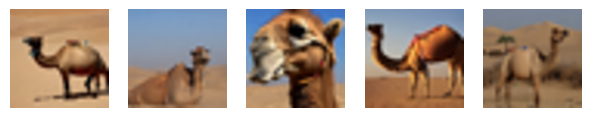

Neuron 211
Average: 43260.4, Median: 43152, No Outlier Avg.: 43260.4
CLIP-dissect Label: rocking chair
Ground Truth: German short-haired pointer


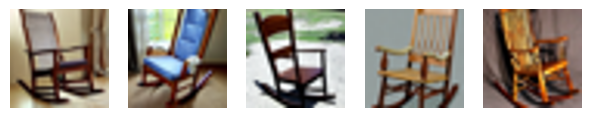

Neuron 309
Average: 40315.4, Median: 45079, No Outlier Avg.: 40315.4
CLIP-dissect Label: Arabian camel
Ground Truth: fly


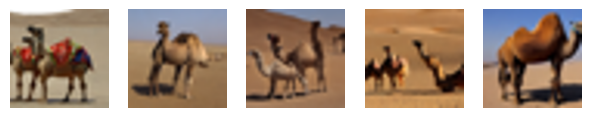

Neuron 435
Average: 34992.2, Median: 39257, No Outlier Avg.: 41612.0
CLIP-dissect Label: Arabian camel
Ground Truth: bath towel


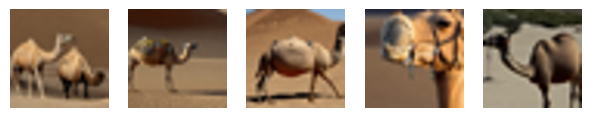

Neuron 665
Average: 42013.4, Median: 43119, No Outlier Avg.: 43757.0
CLIP-dissect Label: Arabian camel
Ground Truth: monitor


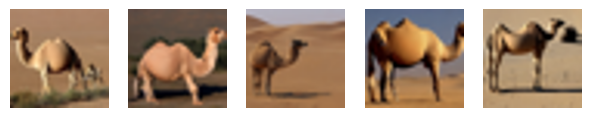

Neuron 714
Average: 40680.4, Median: 43008, No Outlier Avg.: 43720.25
CLIP-dissect Label: Arabian camel
Ground Truth: photocopier


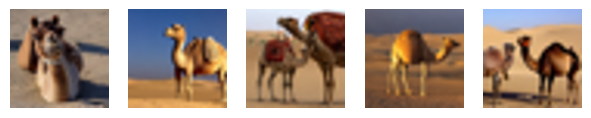

Neuron 948
Average: 20323.4, Median: 19312, No Outlier Avg.: 20323.4
CLIP-dissect Label: Arabian camel
Ground Truth: mushroom


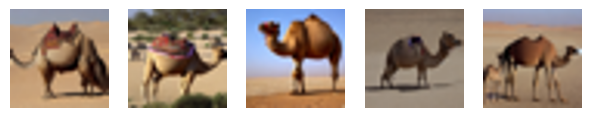

Neuron 972
Average: 33105.0, Median: 32809, No Outlier Avg.: 37509.0
CLIP-dissect Label: Arabian camel
Ground Truth: bubble


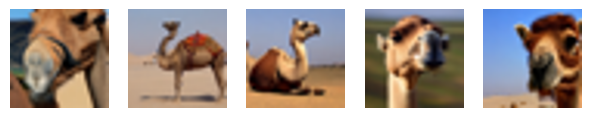

In [52]:
import torchvision.transforms as transforms
import math
import statistics
similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name,
                                                             text_save_name, similarity_fn, new_target_save_name,
                                                             new_clip_save_name, new_set = True, device=device)

top_vals, top_ids = torch.sort(target_feats, dim=0, descending = True)

print(target_feats.shape)

result = {id:[] for id in add_im_id}

for neuron_id in add_im_id:
  top_image_ids = top_ids[:,neuron_id]
  for check_id in add_im_id[neuron_id]:
    for i,image_id in enumerate(top_image_ids):
      if image_id == check_id:
        result[neuron_id].append(i + 1)
  result[neuron_id].sort()

median_rank = {}
no_outlier_avg_rank = {}
avg_rank = {}
for neuron_id in add_im_id:
  median_rank[neuron_id] = statistics.median(result[neuron_id])
  Q1,Q3 = np.quantile(np.array(result[neuron_id]), [0.25,0.75])
  IQR = Q3 - Q1
  avg = 0
  no_outlier_avg = 0
  non_outlier_cnt = 0
  for pos in result[neuron_id]:
    avg += pos
    if pos >= Q1 - (1.5 * IQR) and pos <= Q3 + (1.5 * IQR):
      no_outlier_avg += pos
      non_outlier_cnt += 1
  avg_rank[neuron_id] = avg / len(result[neuron_id])
  no_outlier_avg_rank[neuron_id] = no_outlier_avg / (non_outlier_cnt)

# Print position of specific labels

for neuron_id in add_im_id:
  for pos in result[neuron_id]:
    print('Neuron {} Pos {}'.format(neuron_id, pos))
  print('\n')
print('\n')

# avg_pos = {}
# for neuron_id in result:
#   avg = 0
#   for pos in result[neuron_id]:
#     avg += pos
#   avg /= len(result[neuron_id])
#   avg_pos[neuron_id] = avg

for neuron_id in result:
  print('Neuron {}'.format(neuron_id + 1))
  print('Average: {}, Median: {}, No Outlier Avg.: {}'.format(avg_rank[neuron_id], median_rank[neuron_id], no_outlier_avg_rank[neuron_id]))
  print('CLIP-dissect Label: {}'.format(predicted_words[neuron_id]))
  print('Ground Truth: {}'.format(words[int(neuron_id)]))

  fig = plt.figure(figsize=(15, 7))
  for i in range(len(add_im_id[neuron_id])):
    im = add_im[add_im_id[neuron_id][i]]
    im = im.resize([375,375])
    fig.add_subplot(1, 10, i+1)
    plt.imshow(im)
    plt.axis('off')
  plt.show()

In [24]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
from transformers import pipeline

model = SentenceTransformer('all-mpnet-base-v2')
clip_model, clip_preprocess = clip.load(clip_name, device=device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=3d1efbd4d12e2d603870c0b440ec9a975c163c7b2e95b860d5b31994121f18c4
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 2.2.0
    Uninstalling sentence-transformers-2.2.0:
      Successfully uninstalled sentence-transformers-2.2.0


In [53]:
# Get cos similarity between concepts
from google.colab import files
for orig_id in result:
  gt = words[int(orig_id)]
  preds = predicted_words[int(orig_id)]

  clip_cos, mpnet_cos = utils.get_cos_similarity(preds, gt, clip_model, model, device, batch_size)

  print("Neuron {} 3rd label: clip_cos - {}, mpnet_cos - {}".format(orig_id, clip_cos, mpnet_cos))

# Save results
df = pd.DataFrame(columns = ['Neuron ID','Image #','Median Rank','CLIP sim'])

for i, neuron_id in enumerate(add_im_id):
  gt = words[int(neuron_id)]
  preds = predicted_words[int(neuron_id)]

  clip_cos, mpnet_cos = utils.get_cos_similarity(preds, gt, clip_model, model, device, batch_size)
  pd_row = [neuron_id, i, median_rank[neuron_id], clip_cos]
  df.loc[len(df)] = pd_row

df.to_csv('1000_labels.csv')
files.download('1000_labels.csv')



Neuron 12 3rd label: clip_cos - 0.52197265625, mpnet_cos - 0.1332474648952484
Neuron 210 3rd label: clip_cos - 0.44482421875, mpnet_cos - 0.09216716885566711
Neuron 308 3rd label: clip_cos - 0.69091796875, mpnet_cos - 0.1554432213306427
Neuron 434 3rd label: clip_cos - 0.57763671875, mpnet_cos - 0.1571996957063675
Neuron 664 3rd label: clip_cos - 0.64013671875, mpnet_cos - 0.13433770835399628
Neuron 713 3rd label: clip_cos - 0.56787109375, mpnet_cos - 0.14251631498336792
Neuron 947 3rd label: clip_cos - 0.677734375, mpnet_cos - 0.1324281394481659
Neuron 971 3rd label: clip_cos - 0.64111328125, mpnet_cos - 0.13534849882125854


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>